# Fit Chl

In [14]:
# imports

from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments

from cnmf.oceanography import iops
from cnmf import zhu_nmf as nmf
from cnmf import io as cnmf_io

In [8]:
%matplotlib ipympl

# Load L23

In [4]:
nmf_fit, N_NMF, iop = 'L23', 4, 'a'
d = cnmf_io.load_nmf(nmf_fit, N_NMF, iop)
M = d['M']
coeff = d['coeff']
wave = d['wave']

# Load Chl pigments

In [7]:
chla = pigments.a_chl(wave, ctype='a')
chlb = pigments.a_chl(wave, ctype='b')
chlc = pigments.a_chl(wave, ctype='c12')

# Plot

In [15]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

nrm: 63.89111740879899
nrm: 230.83186835702705
nrm: 90.45953546811074


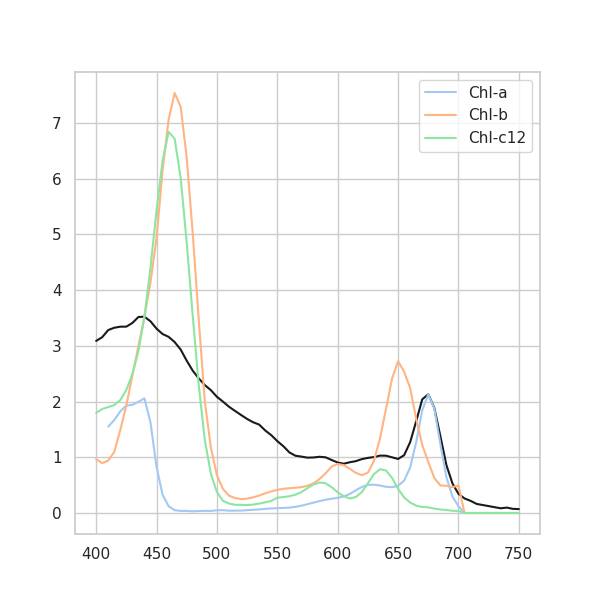

In [38]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# Basis function
ax.plot(wave, M[0], color='k')

# Chl
for pig, wv, lbl in zip([chla,chlb,chlc], [673.,440.,440.], ['a', 'b', 'c12']):
    iwv = np.argmin(np.abs(wave-wv))
    nrm = pig[iwv]/M[0,iwv]
    print(f'nrm: {1/nrm}')
    ax.plot(wave, pig/nrm, label=f'Chl-{lbl}')

ax.legend()
plt.show()

# Fit

## Cut on wavelengths

In [44]:
gd1 = (wave > 420.) & (wave < 471.)
gd2 = (wave > 589.) & (wave < 700.)
gd_wave = gd1 | gd2
gd_wave

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False])

In [68]:
reload(pigments)
ans, cov = pigments.fit_a_chl(wave[gd_wave], M[0, gd_wave])

In [69]:
ans

array([67.99483674, 35.84864334, 26.56877987])

## Ans

In [47]:
model = ans[0]*chla + ans[1]*chlb + ans[2]*chlc

## Plot

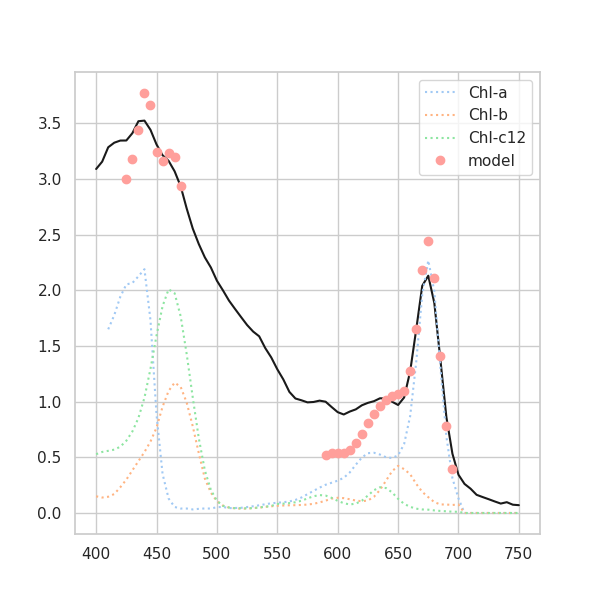

In [48]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# Basis function
ax.plot(wave, M[0], color='k')

# Chl
for ss, pig, wv, lbl in zip(range(3), [chla,chlb,chlc], [673.,440.,440.], ['a', 'b', 'c12']):
    #iwv = np.argmin(np.abs(wave-wv))
    #nrm = pig[iwv]/M[0,iwv]
    #print(f'nrm: {1/nrm}')
    ax.plot(wave, pig*ans[ss], label=f'Chl-{lbl}', ls=':')

ax.plot(wave[gd_wave], model[gd_wave], 'o', label='model')

ax.legend()
plt.show()

# Missing pigments?

## Load em

In [51]:
reload(pigments)
peri = pigments.a_chl(wave, pigment='Peri')
beta = pigments.a_chl(wave, pigment='beta-Car')

## Plot em

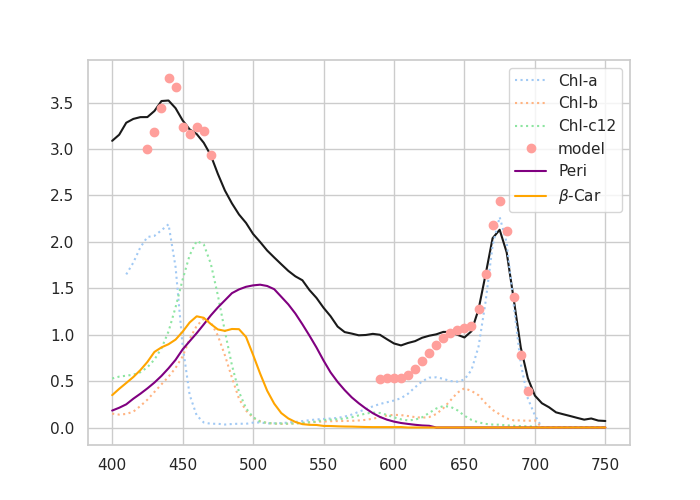

In [58]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

# Basis function
ax.plot(wave, M[0], color='k')

# Chl
for ss, pig, wv, lbl in zip(range(3), [chla,chlb,chlc], [673.,440.,440.], ['a', 'b', 'c12']):
    #iwv = np.argmin(np.abs(wave-wv))
    #nrm = pig[iwv]/M[0,iwv]
    #print(f'nrm: {1/nrm}')
    ax.plot(wave, pig*ans[ss], label=f'Chl-{lbl}', ls=':')

ax.plot(wave[gd_wave], model[gd_wave], 'o', label='model')

# New ones
ax.plot(wave, peri*50, color='purple', label='Peri')
ax.plot(wave, beta*20, color='orange', label=r'$\beta$-Car')

ax.legend()
plt.show()

# Let's include these 2 new pigments in our fit

## Expand the wavelengths

In [60]:
gd1 = (wave > 420.) & (wave < 550.)
gd2 = (wave > 589.) & (wave < 700.)
gd_wave2 = gd1 | gd2

In [70]:
reload(pigments)
ans, cov = pigments.fit_a_chl(wave[gd_wave2], M[0, gd_wave2], 
                             add_pigments=[peri[gd_wave2], beta[gd_wave2]])

In [71]:
ans

array([69.52903927, 34.12205813, 11.36176575, 63.14122147, -4.28564904])

## New model

In [72]:
new_model = ans[0]*chla + ans[1]*chlb + ans[2]*chlc + ans[3]*peri + ans[4]*beta

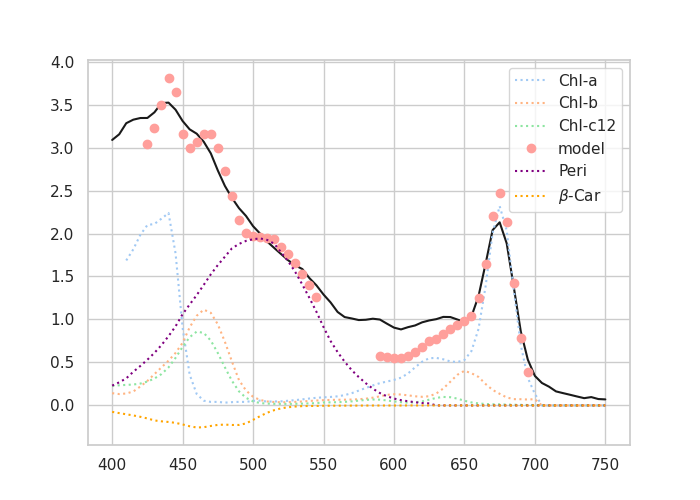

In [75]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

# Basis function
ax.plot(wave, M[0], color='k')

# Chl
for ss, pig, wv, lbl in zip(range(3), [chla,chlb,chlc], [673.,440.,440.], ['a', 'b', 'c12']):
    #iwv = np.argmin(np.abs(wave-wv))
    #nrm = pig[iwv]/M[0,iwv]
    #print(f'nrm: {1/nrm}')
    ax.plot(wave, pig*ans[ss], label=f'Chl-{lbl}', ls=':')

ax.plot(wave[gd_wave2], new_model[gd_wave2], 'o', label='model')

# New ones
ax.plot(wave, peri*ans[3], color='purple', label='Peri', ls=':')
ax.plot(wave, beta*ans[4], color='orange', label=r'$\beta$-Car', ls=':')

ax.legend()
plt.show()

----

# Test

In [66]:
def func(*pargs):
    import pdb; pdb.set_trace()
    return

In [67]:
func(1., 2, 4, 7)

> /tmp/ipykernel_174273/2627591610.py(3)func()
      1 def func(*pargs):
      2     import pdb; pdb.set_trace()
----> 3     return



ipdb>  pargs[0]


1.0


ipdb>  exit
